# **Tasks for the final exam**


 **Hakobyan Marta**

1. Continue the task for applications-gen data
    - enricher
        a. Create a day-0 state for a userDevice table (described below)
        b. Create enrich_user_device() function
        to run daily and create a daily state of userDevice table

In [1]:
!git clone https://github.com/ggh96/bdt-ysu-2025.git


Cloning into 'bdt-ysu-2025'...
remote: Enumerating objects: 1231, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1231 (delta 7), reused 17 (delta 5), pack-reused 1210 (from 2)
Receiving objects: 100% (1231/1231), 164.05 MiB | 14.45 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (1204/1204), done.


In [2]:
#Preparing Spark in Colab
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window

spark = SparkSession.builder\
    .appName("userDevice")\
    .getOrCreate()

base_path = "/content/bdt-ysu-2025/data/applications-gen/raw"


In [3]:
#Day-0: Code Example
#Reading data for a specific date
from datetime import date

day0 = "2025-12-03"

sessions_df = spark.read.parquet(f"{base_path}/sessions/{day0}")
apps_df     = spark.read.parquet(f"{base_path}/applications/{day0}")
hw_df       = spark.read.parquet(f"{base_path}/hardware/{day0}")
upd_df      = spark.read.parquet(f"{base_path}/updateEvents/{day0}")
users_df    = spark.read.parquet(f"{base_path}/users/{day0}")


In [5]:
from pyspark.sql import functions as F

sessions_df = spark.read.parquet(f"{base_path}/sessions/{day0}")

sessions_df = sessions_df.select(
    F.col("userid").alias("userId"),
    F.col("deviceid").alias("deviceId"),
    "sessionid",
    "clientTs",
    "serverTs",
    "sessionDuration",
    "actions",
    "applicationName",
    "powerMode",
    "batteryPercent",
    "uiSettings"
)


In [9]:
#Day-0 snapshot


base_path = "/content/bdt-ysu-2025/data/applications-gen/raw"
day0 = "2025-12-03"

#  Sessions - registerTs, lastActivityTs, lastSessionTs

sessions_raw = spark.read.parquet(f"{base_path}/sessions/{day0}")

sessions_raw.printSchema()
# # We bring to a single scheme: user Id, device Id, events

sessions = sessions_raw.select(
    F.col("userid").alias("userId"),
    F.col("deviceid").alias("deviceId"),
    F.col("clientTs").alias("eventTs")
)

# registerTs, lastActivityTs, lastSessionTs
user_device_base = (
    sessions
    .groupBy("userId", "deviceId")
    .agg(
        F.min("eventTs").alias("registerTs"),
        F.max("eventTs").alias("lastActivityTs"),
        F.max("eventTs").alias("lastSessionTs")  # last session = last activity by sessions
    )
)


#  applications- applications (map/struct per device)


apps_raw = spark.read.parquet(f"{base_path}/applications/{day0}")

apps_raw.printSchema()


apps = apps_raw.select(
    F.col("deviceid").alias("deviceId"),
    F.col("installedApps").alias("applications")
)


#hardware (array<struct>)


hw_raw = spark.read.parquet(f"{base_path}/hardware/{day0}")

hw_raw.printSchema()


# remove duplicates by device ID
hw_dedup = hw_raw.dropDuplicates(["deviceid"])

hw = (
    hw_dedup
    .select(
        F.col("deviceid").alias("deviceId"),
        F.array(
            F.struct(
                F.col("cpu"),
                F.col("ramGb").alias("ram"),
                F.col("os"),
                F.col("formFactor").alias("deviceType")
            )
        ).alias("hardware")
    )
)


#  userDevice day-0


user_device_day0 = (
    user_device_base
    .join(apps, on="deviceId", how="left")
    .join(hw, on="deviceId", how="left")
    .withColumn("snapshotDate", F.lit(day0))
)

user_device_day0.printSchema()
user_device_day0.show(10, truncate=False)


# save snapshot

user_device_day0.write.mode("overwrite") \
    .partitionBy("snapshotDate") \
    .parquet(f"{base_path}/userDevice")


root
 |-- userid: string (nullable = true)
 |-- deviceid: string (nullable = true)
 |-- sessionid: string (nullable = true)
 |-- clientTs: timestamp (nullable = true)
 |-- serverTs: timestamp (nullable = true)
 |-- sessionDuration: double (nullable = true)
 |-- actions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- action: string (nullable = true)
 |    |    |-- ts: timestamp (nullable = true)
 |-- applicationName: string (nullable = true)
 |-- powerMode: string (nullable = true)
 |-- batteryPercent: integer (nullable = true)
 |-- uiSettings: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)

root
 |-- deviceid: string (nullable = true)
 |-- installedApps: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)

root
 |-- deviceid: string (nullable = true)
 |-- cpu: string (nullable = true)
 |-- ramGb: long (nullable = true)
 |-- os: string (nullable = true)
 |--

In [10]:
#Create enrich_user_device() function
#to run daily and create a daily state of userDevice table

from datetime import datetime, timedelta

base_path = "/content/bdt-ysu-2025/data/applications-gen/raw"

def enrich_user_device(processDate: str):
    # determine yesterday's dat
    d = datetime.strptime(processDate, "%Y-%m-%d")
    prevDate = (d - timedelta(days=1)).strftime("%Y-%m-%d")
    print(f"Enriching snapshot for {processDate}, previous date = {prevDate}")

    #  yesterday's snapshot userDevice
    prev_ud = spark.read.parquet(f"{base_path}/userDevice/snapshotDate={prevDate}")

    prev = prev_ud.select(
        "deviceId",
        "userId",
        F.col("registerTs").alias("registerTs_prev"),
        F.col("lastActivityTs").alias("lastActivityTs_prev"),
        F.col("lastSessionTs").alias("lastSessionTs_prev"),
        F.col("applications").alias("applications_prev"),
        F.col("hardware").alias("hardware_prev")
    )

    # sessions - processDate
    sessions_raw = spark.read.parquet(f"{base_path}/sessions/{processDate}")

    sessions = sessions_raw.select(
        F.col("userid").alias("userId"),
        F.col("deviceid").alias("deviceId"),
        F.col("clientTs").alias("eventTs")
    )

    daily_sessions = (
        sessions
        .groupBy("userId", "deviceId")
        .agg(
            F.min("eventTs").alias("minEventTs"),
            F.max("eventTs").alias("maxEventTs")
        )
        .withColumn("dayLastSessionTs", F.col("maxEventTs"))  # для ясности
    )

    # Connecting yesterday's snapshot and today's session
    joined = prev.join(
        daily_sessions,
        on=["deviceId", "userId"],
        how="full_outer"
    )

    #  restart timestamps
    result = (
        joined
        # registerTs: old if any, otherwise first eventTs today
        .withColumn(
            "registerTs",
            F.when(F.col("registerTs_prev").isNotNull(), F.col("registerTs_prev"))
             .otherwise(F.col("minEventTs"))
        )
        # lastActivityTs: the maximum of the old and the present
        .withColumn(
            "lastActivityTs",
            F.greatest(F.col("lastActivityTs_prev"), F.col("maxEventTs"))
        )
        # lastSessionTs: the maximum of the old and the present
        .withColumn(
            "lastSessionTs",
            F.greatest(F.col("lastSessionTs_prev"), F.col("dayLastSessionTs"))
        )
    )

    # applications - processDate
    apps_raw = spark.read.parquet(f"{base_path}/applications/{processDate}")

    apps_today = apps_raw.select(
        F.col("deviceid").alias("deviceId"),
        F.col("installedApps").alias("applications_today")
    )

    #  hardware - processDate
    hw_raw = spark.read.parquet(f"{base_path}/hardware/{processDate}")
    hw_dedup = hw_raw.dropDuplicates(["deviceid"])

    hw_today = (
        hw_dedup
        .select(
            F.col("deviceid").alias("deviceId"),
            F.array(
                F.struct(
                    F.col("cpu"),
                    F.col("ramGb").alias("ram"),
                    F.col("os"),
                    F.col("formFactor").alias("deviceType")
                )
            ).alias("hardware_today")
        )
    )

    #Pulling up new apps and hardware by deviceId
    result2 = (
        result
        .join(apps_today, on="deviceId", how="left")
        .join(hw_today, on="deviceId", how="left")
    )

    # restart applications и hardware
    result2 = (
        result2
        .withColumn(
            "applications",
            F.when(F.col("applications_today").isNotNull(), F.col("applications_today"))
             .otherwise(F.col("applications_prev"))
        )
        .withColumn(
            "hardware",
            F.when(F.col("hardware_today").isNotNull(), F.col("hardware_today"))
             .otherwise(F.col("hardware_prev"))
        )
    )

    # final snapshot
    final = (
        result2
        .select(
            "deviceId",
            "userId",
            "registerTs",
            "lastActivityTs",
            "lastSessionTs",
            "applications",
            "hardware"
        )
        .withColumn("snapshotDate", F.lit(processDate))
    )

    final.write.mode("append") \
         .partitionBy("snapshotDate") \
         .parquet(f"{base_path}/userDevice")

    print(f"Snapshot for {processDate} written to {base_path}/userDevice")


In [11]:
dates = [
    "2025-12-04",
    "2025-12-05",
    "2025-12-06",
    "2025-12-07",
    "2025-12-08",
    "2025-12-09",
]

for d in dates:
    enrich_user_device(d)


Enriching snapshot for 2025-12-04, previous date = 2025-12-03
Snapshot for 2025-12-04 written to /content/bdt-ysu-2025/data/applications-gen/raw/userDevice
Enriching snapshot for 2025-12-05, previous date = 2025-12-04
Snapshot for 2025-12-05 written to /content/bdt-ysu-2025/data/applications-gen/raw/userDevice
Enriching snapshot for 2025-12-06, previous date = 2025-12-05
Snapshot for 2025-12-06 written to /content/bdt-ysu-2025/data/applications-gen/raw/userDevice
Enriching snapshot for 2025-12-07, previous date = 2025-12-06
Snapshot for 2025-12-07 written to /content/bdt-ysu-2025/data/applications-gen/raw/userDevice
Enriching snapshot for 2025-12-08, previous date = 2025-12-07
Snapshot for 2025-12-08 written to /content/bdt-ysu-2025/data/applications-gen/raw/userDevice
Enriching snapshot for 2025-12-09, previous date = 2025-12-08
Snapshot for 2025-12-09 written to /content/bdt-ysu-2025/data/applications-gen/raw/userDevice


Display userDevice for several dates at once and see how applications and hardware change

In [13]:
dates = ["2025-12-03", "2025-12-04", "2025-12-05"]

ud_some = (
    ud_all
    .filter(F.col("snapshotDate").isin(dates))
)

ud_some.select("deviceId", "userId", "snapshotDate").orderBy("deviceId", "userId", "snapshotDate").show(50, truncate=False)


+---------+---------+------------+
|deviceId |userId   |snapshotDate|
+---------+---------+------------+
|device_0 |user_2266|2025-12-03  |
|device_0 |user_2266|2025-12-04  |
|device_0 |user_2266|2025-12-05  |
|device_0 |user_2401|2025-12-03  |
|device_0 |user_2401|2025-12-04  |
|device_0 |user_2401|2025-12-05  |
|device_0 |user_3365|2025-12-05  |
|device_0 |user_3868|2025-12-05  |
|device_0 |user_4104|2025-12-04  |
|device_0 |user_4104|2025-12-05  |
|device_0 |user_4636|2025-12-05  |
|device_0 |user_4685|2025-12-03  |
|device_0 |user_4685|2025-12-04  |
|device_0 |user_4685|2025-12-05  |
|device_0 |user_4866|2025-12-04  |
|device_0 |user_4866|2025-12-05  |
|device_0 |user_623 |2025-12-05  |
|device_1 |user_1146|2025-12-03  |
|device_1 |user_1146|2025-12-04  |
|device_1 |user_1146|2025-12-05  |
|device_1 |user_1697|2025-12-03  |
|device_1 |user_1697|2025-12-04  |
|device_1 |user_1697|2025-12-05  |
|device_1 |user_2319|2025-12-04  |
|device_1 |user_2319|2025-12-05  |
|device_1 |user_24  

In [14]:
#Tracking by one device/user
target_device = "device_1345"
target_user   = "user_380"

history = (
    ud_all
    .filter(
        (F.col("deviceId") == target_device) &
        (F.col("userId") == target_user)
    )
    .orderBy("snapshotDate")
)

history.select(
    "snapshotDate",
    "applications",
    "hardware"
).show(truncate=False)


+------------+----------------------------------------------------------------------------------------------------------------+------------------------------------+
|snapshotDate|applications                                                                                                    |hardware                            |
+------------+----------------------------------------------------------------------------------------------------------------+------------------------------------+
|2025-12-03  |{IntelliJ -> 3.1, PyCharm -> 4.0, VSCode -> 2.0, Chrome -> 4.0, Discord -> 2.0, Edge -> 3.1}                    |[{Ryzen 7, 8, Windows 10, Desktop}] |
|2025-12-04  |{Illustrator -> 2.0, Steam -> 2.0, VSCode -> 1.0, Chrome -> 3.1, Teams -> 2.0, Photoshop -> 3.1, Firefox -> 4.0}|[{Intel i5, 8, Windows 10, Desktop}]|
|2025-12-05  |{PyCharm -> 1.0, Slack -> 3.1, EpicGames -> 3.1, Outlook -> 2.0, Steam -> 2.0, Teams -> 3.1, Edge -> 2.0}       |[{Intel i5, 16, Linux, Desktop}]    |
|2025-12-0

In [15]:
#Expand hardware into separate columns
history_hw = (
    history
    .withColumn("hw0", F.element_at("hardware", 1))  # 1-й элемент массива
    .select(
        "snapshotDate",
        F.col("hw0.cpu").alias("cpu"),
        F.col("hw0.ram").alias("ram"),
        F.col("hw0.os").alias("os"),
        F.col("hw0.deviceType").alias("deviceType")
    )
    .orderBy("snapshotDate")
)

history_hw.show(truncate=False)


+------------+--------+---+----------+----------+
|snapshotDate|cpu     |ram|os        |deviceType|
+------------+--------+---+----------+----------+
|2025-12-03  |Ryzen 7 |8  |Windows 10|Desktop   |
|2025-12-04  |Intel i5|8  |Windows 10|Desktop   |
|2025-12-05  |Intel i5|16 |Linux     |Desktop   |
|2025-12-06  |Ryzen 7 |32 |Windows 11|Laptop    |
|2025-12-07  |Ryzen 7 |32 |Windows 11|Laptop    |
|2025-12-08  |Ryzen 7 |32 |Windows 11|Laptop    |
|2025-12-09  |Ryzen 7 |32 |Windows 11|Laptop    |
+------------+--------+---+----------+----------+



In [16]:
#how a specific app version changes
history_apps = (
    history
    .select(
        "snapshotDate",
        F.col("applications")["VSCode"].alias("VSCode_version"),
        F.col("applications")["Chrome"].alias("Chrome_version"),
        F.col("applications")["PyCharm"].alias("PyCharm_version")
    )
    .orderBy("snapshotDate")
)

history_apps.show(truncate=False)


+------------+--------------+--------------+---------------+
|snapshotDate|VSCode_version|Chrome_version|PyCharm_version|
+------------+--------------+--------------+---------------+
|2025-12-03  |2.0           |4.0           |4.0            |
|2025-12-04  |1.0           |3.1           |NULL           |
|2025-12-05  |NULL          |NULL          |1.0            |
|2025-12-06  |1.0           |NULL          |NULL           |
|2025-12-07  |1.0           |NULL          |NULL           |
|2025-12-08  |1.0           |NULL          |NULL           |
|2025-12-09  |1.0           |NULL          |NULL           |
+------------+--------------+--------------+---------------+



In [17]:
history_maps = (
    history
    .select(
        "snapshotDate",
        F.map_keys("applications").alias("apps"),
        F.map_values("applications").alias("versions")
    )
    .orderBy("snapshotDate")
)

history_maps.show(truncate=False)


+------------+---------------------------------------------------------------+-----------------------------------+
|snapshotDate|apps                                                           |versions                           |
+------------+---------------------------------------------------------------+-----------------------------------+
|2025-12-03  |[IntelliJ, PyCharm, VSCode, Chrome, Discord, Edge]             |[3.1, 4.0, 2.0, 4.0, 2.0, 3.1]     |
|2025-12-04  |[Illustrator, Steam, VSCode, Chrome, Teams, Photoshop, Firefox]|[2.0, 2.0, 1.0, 3.1, 2.0, 3.1, 4.0]|
|2025-12-05  |[PyCharm, Slack, EpicGames, Outlook, Steam, Teams, Edge]       |[1.0, 3.1, 3.1, 2.0, 2.0, 3.1, 2.0]|
|2025-12-06  |[IntelliJ, VSCode, Slack, Illustrator, Steam]                  |[4.0, 1.0, 4.0, 2.0, 2.0]          |
|2025-12-07  |[IntelliJ, VSCode, Slack, Illustrator, Steam]                  |[4.0, 1.0, 4.0, 2.0, 2.0]          |
|2025-12-08  |[IntelliJ, VSCode, Slack, Illustrator, Steam]                  |[4

       ** Create functions for daily aggregations**
            a. aggregate_total_n_of_users_so_far_daily() # a cumulative number showing nOfUsers that join us so far
           

In [18]:
from pyspark.sql import functions as F, Window

base_path = "/content/bdt-ysu-2025/data/applications-gen/raw"

def aggregate_total_n_of_users_so_far_daily():
    # all sessions
    sessions_raw = spark.read.parquet(f"{base_path}/sessions/*")

    sessions = sessions_raw.select(
        F.col("userid").alias("userId"),
        F.to_date(F.col("clientTs")).alias("eventDate")
    ).dropna(subset=["userId", "eventDate"])

    # first date
    user_first_date = (
        sessions
        .groupBy("userId")
        .agg(F.min("eventDate").alias("firstDate"))
    )

    # new users by date
    new_users_by_date = (
        user_first_date
        .groupBy("firstDate")
        .agg(F.count("*").alias("newUsers"))
        .withColumnRenamed("firstDate", "eventDate")
    )


    w = Window.orderBy("eventDate").rowsBetween(Window.unboundedPreceding, Window.currentRow)

    result = (
        new_users_by_date
        .withColumn("totalUsersSoFar", F.sum("newUsers").over(w))
        .orderBy("eventDate")
    )

    # save
    out_path = f"{base_path}/aggregates/total_users_daily"
    result.write.mode("overwrite").parquet(out_path)

    print(f"Written daily total users aggregate to {out_path}")
    return result


In [19]:
total_users_df = aggregate_total_n_of_users_so_far_daily()
total_users_df.show(20, truncate=False)


Written daily total users aggregate to /content/bdt-ysu-2025/data/applications-gen/raw/aggregates/total_users_daily
+----------+--------+---------------+
|eventDate |newUsers|totalUsersSoFar|
+----------+--------+---------------+
|2025-12-02|2492    |2492           |
|2025-12-03|2463    |4955           |
|2025-12-04|45      |5000           |
+----------+--------+---------------+



     Create functions for daily aggregations
           
            b. aggregate_n_of_installs_uninstalls_daily() # daily number of install and uninstall events

In [27]:

base_path = "/content/bdt-ysu-2025/data/applications-gen/raw"

def aggregate_n_of_installs_uninstalls_daily():
    # all updateEvents
    upd_raw = spark.read.parquet(f"{base_path}/updateEvents/*")

    upd_raw.printSchema()

    events = (
        upd_raw
        .select(
            F.to_date(F.col("eventTs")).alias("eventDate"),
            F.col("eventType")
        )
        .dropna(subset=["eventDate", "eventType"])
    )

    # events
    agg = (
        events
        .groupBy("eventDate", "eventType")
        .agg(F.count("*").alias("nEvents"))
    )

    pivoted = (
        agg
        .groupBy("eventDate")
        .pivot("eventType", ["optimized", "updated", "killed"])
        .agg(F.first("nEvents"))
        .fillna(0)
        .orderBy("eventDate")
    )

    #  install / uninstall
    result = (
        pivoted
        .withColumn("nInstalls",   F.col("optimized") + F.col("updated"))
        .withColumn("nUninstalls", F.col("killed"))
        .select(
            "eventDate",
            "nInstalls",
            "nUninstalls",
            "optimized",
            "updated",
            "killed"
        )
        .orderBy("eventDate")
    )

    # save
    out_path = f"{base_path}/aggregates/installs_uninstalls_daily"
    result.write.mode("overwrite").parquet(out_path)

    print(f"Written daily install/uninstall aggregate to {out_path}")
    return result


In [28]:
inst_uninst_df = aggregate_n_of_installs_uninstalls_daily()
inst_uninst_df.show(20, truncate=False)


root
 |-- deviceid: string (nullable = true)
 |-- application: string (nullable = true)
 |-- eventType: string (nullable = true)
 |-- eventTs: timestamp (nullable = true)

Written daily install/uninstall aggregate to /content/bdt-ysu-2025/data/applications-gen/raw/aggregates/installs_uninstalls_daily
+----------+---------+-----------+---------+-------+------+
|eventDate |nInstalls|nUninstalls|optimized|updated|killed|
+----------+---------+-----------+---------+-------+------+
|2025-12-02|1127     |587        |550      |577    |587   |
|2025-12-03|6945     |3535       |3475     |3470   |3535  |
|2025-12-04|6940     |3444       |3461     |3479   |3444  |
|2025-12-05|6887     |3507       |3435     |3452   |3507  |
|2025-12-06|7081     |3484       |3576     |3505   |3484  |
|2025-12-07|7032     |3419       |3549     |3483   |3419  |
|2025-12-08|6965     |3417       |3505     |3460   |3417  |
|2025-12-09|5733     |2973       |2858     |2875   |2973  |
+----------+---------+-----------+----

 Create at least 3 LOGICAL on different raw datasets, wrap with a function that also reports the found issues

In [29]:


base_path = "/content/bdt-ysu-2025/data/applications-gen/raw"

def dq_sessions(processDate: str):
    df = spark.read.parquet(f"{base_path}/sessions/{processDate}")

    checks = []

    # all rows
    total = df.count()
    checks.append(("sessions", "total_rows", total))

    #  userid/deviceid
    null_ids = df.filter(F.col("userid").isNull() | F.col("deviceid").isNull()).count()
    checks.append(("sessions", "null_user_or_device", null_ids))

    # negative duration
    negative_duration = df.filter(F.col("sessionDuration") < 0).count()
    checks.append(("sessions", "negative_session_duration", negative_duration))

    #  clientTs > serverTs
    inconsistent_ts = df.filter(F.col("clientTs") > F.col("serverTs")).count()
    checks.append(("sessions", "client_after_server_ts", inconsistent_ts))

    # dub (userid, deviceid, sessionid)
    dup_sessions = (
        df.groupBy("userid", "deviceid", "sessionid")
          .count()
          .filter(F.col("count") > 1)
          .count()
    )
    checks.append(("sessions", "duplicate_sessions", dup_sessions))

    return spark.createDataFrame(checks, ["dataset", "check_name", "n_issues"])


In [30]:
def dq_applications(processDate: str):
    df = spark.read.parquet(f"{base_path}/applications/{processDate}")

    checks = []

    total = df.count()
    checks.append(("applications", "total_rows", total))

    #  installedApps is null
    null_apps = df.filter(F.col("installedApps").isNull()).count()
    checks.append(("applications", "null_installedApps", null_apps))

    # installedApps  map
    empty_apps = df.filter(F.size("installedApps") == 0).count()
    checks.append(("applications", "empty_installedApps", empty_apps))

    # too many apps
    too_many_apps = df.filter(F.size("installedApps") > 100).count()
    checks.append(("applications", "too_many_apps_over_100", too_many_apps))

    return spark.createDataFrame(checks, ["dataset", "check_name", "n_issues"])


In [31]:
def dq_hardware(processDate: str):
    df = spark.read.parquet(f"{base_path}/hardware/{processDate}")

    checks = []

    total = df.count()
    checks.append(("hardware", "total_rows", total))

    #  null
    null_hw = df.filter(
        F.col("cpu").isNull() |
        F.col("ramGb").isNull() |
        F.col("os").isNull() |
        F.col("formFactor").isNull()
    ).count()
    checks.append(("hardware", "null_hw_fields", null_hw))

    bad_ram = df.filter((F.col("ramGb") <= 0) | (F.col("ramGb") > 1024)).count()
    checks.append(("hardware", "invalid_ramGb", bad_ram))

    conflicting_hw = (
        df.groupBy("deviceid")
          .agg(
              F.countDistinct(
                  F.struct("cpu", "ramGb", "os", "formFactor")
              ).alias("n_variants")
          )
          .filter(F.col("n_variants") > 1)
          .count()
    )
    checks.append(("hardware", "conflicting_hw_for_same_device", conflicting_hw))

    return spark.createDataFrame(checks, ["dataset", "check_name", "n_issues"])


In [32]:
def run_data_quality_checks(processDate: str):
    dq_s = dq_sessions(processDate)
    dq_a = dq_applications(processDate)
    dq_h = dq_hardware(processDate)

    report = dq_s.union(dq_a).union(dq_h)

    print(f"=== Data Quality Report for {processDate} ===")
    report.show(truncate=False)

    return report


In [33]:
dq_report = run_data_quality_checks("2025-12-03")


=== Data Quality Report for 2025-12-03 ===
+------------+------------------------------+--------+
|dataset     |check_name                    |n_issues|
+------------+------------------------------+--------+
|sessions    |total_rows                    |20000   |
|sessions    |null_user_or_device           |0       |
|sessions    |negative_session_duration     |5085    |
|sessions    |client_after_server_ts        |5085    |
|sessions    |duplicate_sessions            |0       |
|applications|total_rows                    |3500    |
|applications|null_installedApps            |0       |
|applications|empty_installedApps           |0       |
|applications|too_many_apps_over_100        |0       |
|hardware    |total_rows                    |3500    |
|hardware    |null_hw_fields                |0       |
|hardware    |invalid_ramGb                 |0       |
|hardware    |conflicting_hw_for_same_device|0       |
+------------+------------------------------+--------+



# 2. Analyze final/meta-Montana.json

 a. EDA - most popular categories, highest rated categories, etc, + VISUALIZE

In [92]:

df.head()
from pyspark.sql import functions as F

path = "/content/bdt-ysu-2025/data/final/meta-Montana.json"

df = spark.read.json(path)
df.printSchema()
df.show(5, truncate=False)



root
 |-- MISC: struct (nullable = true)
 |    |-- Accessibility: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Activities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Amenities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Atmosphere: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Crowd: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Dining options: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- From the business: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health & safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health and safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Highlights: array (nullable = true)
 |

In [93]:
df.printSchema()
df.describe().show()
df.select("avg_rating", "num_of_reviews").describe().show()


root
 |-- MISC: struct (nullable = true)
 |    |-- Accessibility: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Activities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Amenities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Atmosphere: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Crowd: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Dining options: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- From the business: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health & safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health and safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Highlights: array (nullable = true)
 |

In [94]:
df_exploded = df.select(
    "*",
    F.explode_outer("category").alias("category_exploded")
)

df_exploded.select("gmap_id", "category_exploded").show(10, truncate=False)


+-------------------------------------+---------------------------+
|gmap_id                              |category_exploded          |
+-------------------------------------+---------------------------+
|0x535dc557d042b1f3:0xc419b6f55435c7de|Truck accessories store    |
|0x535dc557d042b1f3:0xc419b6f55435c7de|Diesel engine dealer       |
|0x535dc557d042b1f3:0xc419b6f55435c7de|Used auto parts store      |
|0x535c2690c357f3bd:0x272620bb52fecf11|Ranch                      |
|0x535e9ec3ce050deb:0x2169887374ce879f|Small engine repair service|
|0x535e9ec3ce050deb:0x2169887374ce879f|Garden center              |
|0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76|Hair salon                 |
|0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76|Barber shop                |
|0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76|Beauty salon               |
|0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76|Hairdresser                |
+-------------------------------------+---------------------------+
only showing top 10 rows


 VISUALIZE

In [95]:
top_categories_spark = (
    df.select(F.explode_outer("category").alias("category"))
      .groupBy("category")
      .count()
      .orderBy(F.desc("count"))
      .limit(20)
)


top_categories_pd = top_categories_spark.toPandas()


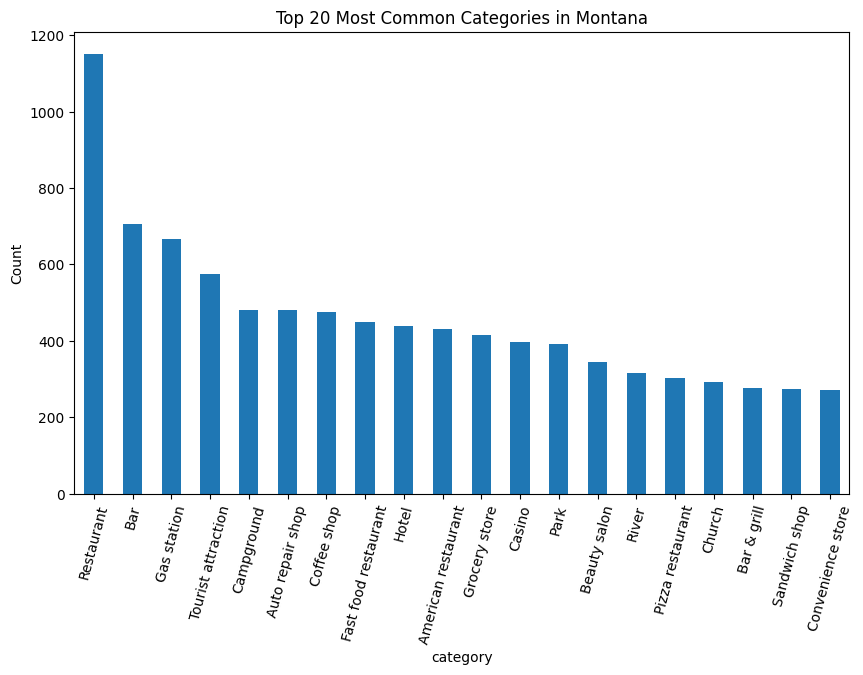

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_categories_pd.set_index("category")["count"].plot(kind="bar")
plt.title("Top 20 Most Common Categories in Montana")
plt.ylabel("Count")
plt.xticks(rotation=75)
plt.show()


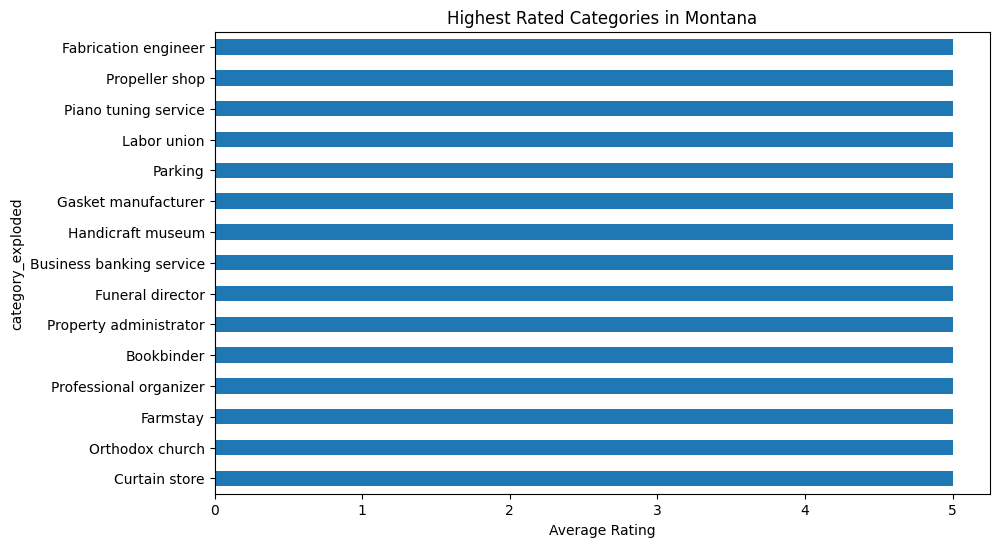

In [98]:
from pyspark.sql import functions as F

cat_rating_spark = (
    df_exploded
        .groupBy("category_exploded")
        .agg(F.mean("avg_rating").alias("avg_rating_mean"))
        .orderBy(F.col("avg_rating_mean").desc())
)
top_rated_pd = cat_rating_spark.limit(15).toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
top_rated_pd.set_index("category_exploded")["avg_rating_mean"].plot(kind="barh")

plt.title("Highest Rated Categories in Montana")
plt.xlabel("Average Rating")
plt.gca().invert_yaxis()
plt.show()


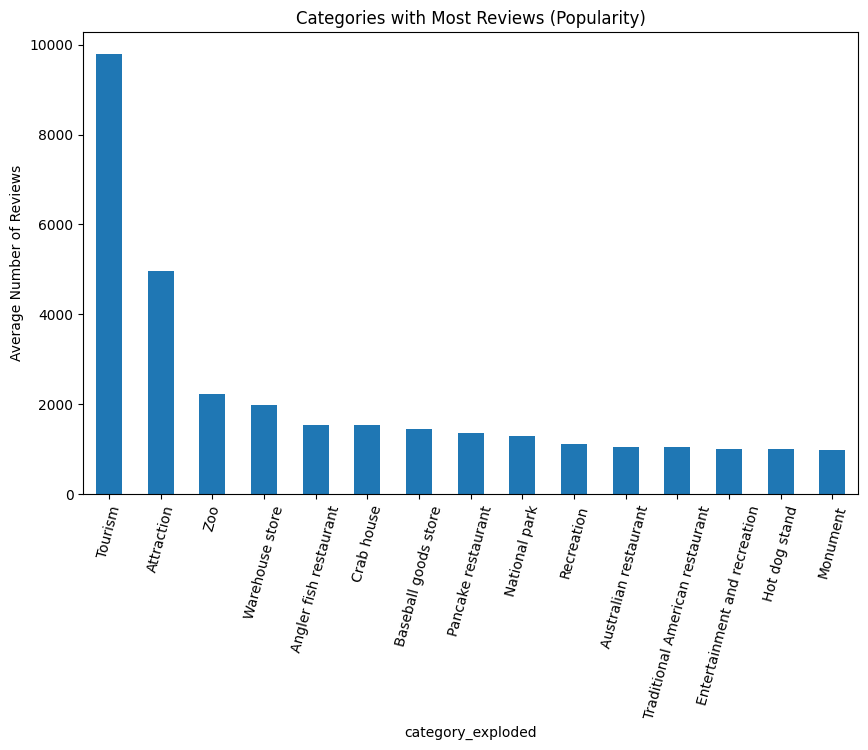

In [99]:
cat_reviews_spark = (
    df_exploded
        .groupBy("category_exploded")
        .agg(F.mean("num_of_reviews").alias("avg_num_reviews"))
        .orderBy(F.col("avg_num_reviews").desc())
)
top_reviews_pd = cat_reviews_spark.limit(15).toPandas()



plt.figure(figsize=(10,6))
top_reviews_pd.set_index("category_exploded")["avg_num_reviews"].plot(kind="bar")

plt.title("Categories with Most Reviews (Popularity)")
plt.ylabel("Average Number of Reviews")
plt.xticks(rotation=75)
plt.show()


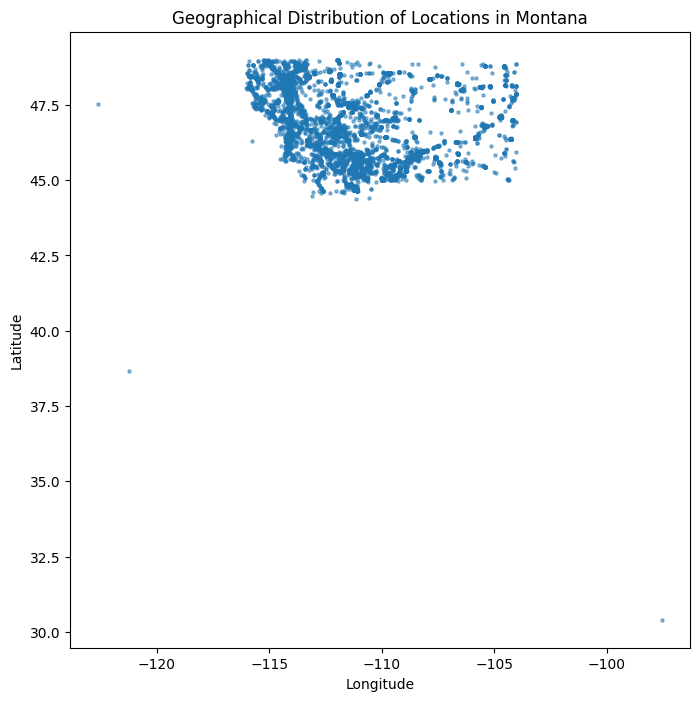

In [100]:
coords_pd = (
    df.select("longitude", "latitude")
      .toPandas()
)


plt.figure(figsize=(8,8))
plt.scatter(coords_pd["longitude"], coords_pd["latitude"], s=5, alpha=0.5)

plt.title("Geographical Distribution of Locations in Montana")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [101]:


top_categories_spark = (
    df_exploded
        .select(F.explode_outer("category").alias("category"))
        .groupBy("category")
        .count()
        .orderBy(F.desc("count"))
        .limit(20)
)

top_categories_pd = top_categories_spark.toPandas()
top_categories_pd


,category,count
0,Restaurant,3986
1,Fast food restaurant,2044
2,Auto repair shop,1880
3,Bar,1618
4,Coffee shop,1466
5,American restaurant,1440
6,Clothing store,1438
7,Takeout Restaurant,1418
8,Gas station,1392
9,Grocery store,1391


b. Analyze the nightlife (9pm to 6am) | weekends vs weekdays | VISUALIZE

In [57]:
def parse_hours_row(hours):
#change format
    parsed = []

    if not isinstance(hours, list):
        return parsed

    for item in hours:
        # item = ['Thursday', '8AM–5PM'] or ['Saturday', 'Closed']
        if not isinstance(item, (list, tuple)) or len(item) < 2:
            continue

        day = str(item[0]).strip()
        times = str(item[1]).strip()

        # skip closed days
        if times.lower() in ("closed", "temporarily closed"):
            continue

        # norm -
        times = times.replace("–", "-")

        # format '8AM-5PM'
        if "-" not in times:
            continue

        open_str, close_str = [t.strip() for t in times.split("-", 1)]

        parsed.append((day, open_str, close_str))

    return parsed


In [103]:
from pyspark.sql.types import StructType, StructField, StringType, ArrayType


hours_schema = ArrayType(
    StructType([
        StructField("day", StringType(), True),
        StructField("open", StringType(), True),
        StructField("close", StringType(), True)
    ])
)

parse_hours_udf = F.udf(parse_hours_row, hours_schema)


In [104]:
df_parsed = df.withColumn("parsed_hours", parse_hours_udf("hours"))


In [105]:
df_parsed = df.withColumn("parsed_hours", parse_hours_udf("hours"))


df_parsed.select("hours", "parsed_hours").show(10, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
|hours                                                                                                                                               |parsed_hours                                                                                                                                               |
+----------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
|[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Saturday, Closed], [Sunday, Closed],

In [111]:
def is_night_row_py(open_str, close_str):
    o = parse_hour_to_int(open_str)
    c = parse_hour_to_int(close_str)

    if o is None or c is None:
        return False

    # 21:00 – 06:00
    if c >= 21:
        return True
    if o < 6:
        return True

    if o == 0 and c == 0:
        return True

    return False


In [112]:


is_night_udf = F.udf(is_night_row_py, BooleanType())


In [114]:
hours_long["is_night"] = hours_long.apply(is_night_row, axis=1)
night_rows = hours_long[hours_long["is_night"] == True]

print("night_rows shape:", night_rows.shape)
night_rows.head()


night_rows shape: (14993, 10)


,gmap_id,category,avg_rating,num_of_reviews,parsed_hours,day,open_str,close_str,is_night,is_weekend
3,0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76,"[Hair salon, Barber shop, Beauty salon, Hairdr...",3.3,38,"(Thursday, 10AM, 9PM)",Thursday,10AM,9PM,True,False
3,0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76,"[Hair salon, Barber shop, Beauty salon, Hairdr...",3.3,38,"(Friday, 10AM, 9PM)",Friday,10AM,9PM,True,True
3,0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76,"[Hair salon, Barber shop, Beauty salon, Hairdr...",3.3,38,"(Saturday, 10AM, 9PM)",Saturday,10AM,9PM,True,True
3,0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76,"[Hair salon, Barber shop, Beauty salon, Hairdr...",3.3,38,"(Monday, 10AM, 9PM)",Monday,10AM,9PM,True,False
3,0x535dcd8d0868cfd1:0xa4bcdf67cf1f3a76,"[Hair salon, Barber shop, Beauty salon, Hairdr...",3.3,38,"(Tuesday, 10AM, 9PM)",Tuesday,10AM,9PM,True,False


VISUALIZE

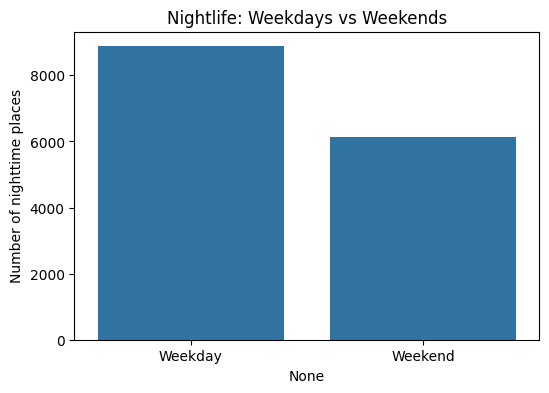

In [65]:
counts = night_rows.groupby("is_weekend").size()
counts.index = ["Weekday", "Weekend"]

plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Nightlife: Weekdays vs Weekends")
plt.ylabel("Number of nighttime places")
plt.show()


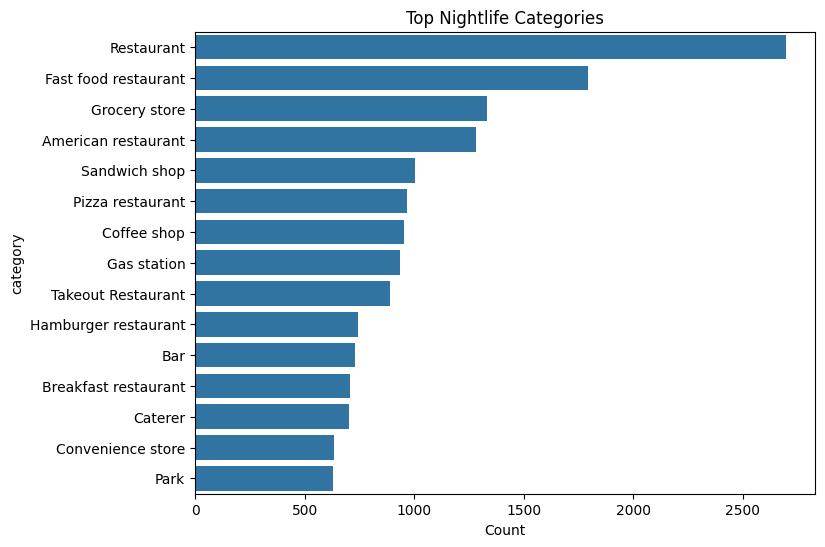

In [66]:
categories = night_rows.explode("category")
top_cat = categories["category"].value_counts().head(15)

plt.figure(figsize=(8,6))
sns.barplot(y=top_cat.index, x=top_cat.values)
plt.title("Top Nightlife Categories")
plt.xlabel("Count")
plt.show()


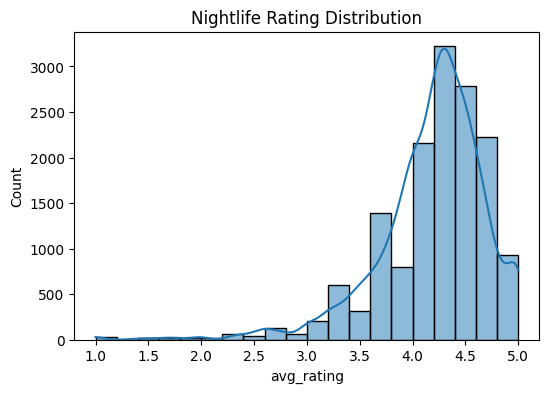

In [67]:
plt.figure(figsize=(6,4))
sns.histplot(night_rows["avg_rating"], bins=20, kde=True)
plt.title("Nightlife Rating Distribution")
plt.show()


c. Why "relative_results" are relative results? What features/categories connect them?

In [124]:

from pyspark.sql.types import ArrayType, StringType

#  category → array
def to_cat_list(c):
    if isinstance(c, list):
        return c
    elif isinstance(c, str):
        return [c]
    else:
        return []

to_cat_list_udf = F.udf(to_cat_list, ArrayType(StringType()))
df_norm = df.withColumn("category_array", to_cat_list_udf("category"))

#  explode relative_results
df_rel = (
    df_norm
        .select(
            F.col("gmap_id").alias("base_id"),
            F.col("category_array").alias("base_categories"),
            F.explode_outer("relative_results").alias("rel_id")
        )
)

#  rel_id → rel_categories
df_cats = (
    df_norm
        .select(
            F.col("gmap_id").alias("rel_id"),
            F.col("category_array").alias("rel_categories")
        )
)

#  join + overlap per pair
joined = (
    df_rel
        .join(df_cats, on="rel_id", how="left")
)

joined = joined.withColumn(
    "overlap",
    F.size(
        F.array_intersect(
            F.coalesce(F.col("base_categories"), F.array().cast("array<string>")),
            F.coalesce(F.col("rel_categories"), F.array().cast("array<string>"))
        )
    )
)

#  avg overlap per base_id
overlap_by_base = (
    joined
        .filter(F.col("rel_id").isNotNull())
        .groupBy("base_id")
        .agg(F.avg("overlap").alias("cat_overlap"))
)

#  back to main df
df_with_overlap = (
    df_norm
        .join(overlap_by_base, df_norm.gmap_id == overlap_by_base.base_id, how="left")
        .drop("base_id")
        .withColumn("cat_overlap", F.coalesce(F.col("cat_overlap"), F.lit(0.0)))
)

#  describe
df_with_overlap.select("cat_overlap").describe().show()


+-------+-------------------+
|summary|        cat_overlap|
+-------+-------------------+
|  count|              21680|
|   mean|0.46161406167632807|
| stddev| 0.5856436877245076|
|    min|                0.0|
|    max|                5.6|
+-------+-------------------+



In [126]:


#  rating lookup table
df_rating = df.select(
    F.col("gmap_id").alias("rel_id"),
    F.col("avg_rating").alias("rel_rating")
)

#  explode relatives
df_rel = (
    df.select("gmap_id", "avg_rating", "relative_results")
      .withColumn("rel_id", F.explode_outer("relative_results"))
)

#  join neighbor ratings
df_rel2 = df_rel.join(df_rating, on="rel_id", how="left")

#  average neighbor rating per object
df_rel_avg = (
    df_rel2
        .groupBy("gmap_id")
        .agg(F.avg("rel_rating").alias("rel_avg_rating"))
)

#  join back to main dataframe
df2 = (
    df
      .join(df_rel_avg, on="gmap_id", how="left")
)

#  abs difference
df2 = df2.withColumn(
    "rating_diff",
    F.abs(F.col("avg_rating") - F.col("rel_avg_rating"))
)

#  describe
df2.select("rating_diff").describe().show()


+-------+-------------------+
|summary|        rating_diff|
+-------+-------------------+
|  count|              17160|
|   mean|0.38119487456988416|
| stddev|0.42407302570493777|
|    min|                0.0|
|    max|                4.0|
+-------+-------------------+



In [127]:

df_reviews = df2.select(
    F.col("gmap_id").alias("rel_id"),
    F.col("num_of_reviews").alias("rel_num_reviews")
)

# 1explode relative_results՝ base object
df_rel = (
    df2.select("gmap_id", "num_of_reviews", "relative_results")
       .withColumn("rel_id", F.explode_outer("relative_results"))
)

#  join neighbors' reviews
df_rel2 = df_rel.join(df_reviews, on="rel_id", how="left")

# reviews for base object
df_rel_avg_reviews = (
    df_rel2
        .groupBy("gmap_id")
        .agg(F.avg("rel_num_reviews").alias("rel_avg_reviews"))
)

#  join back
df3 = (
    df2
      .join(df_rel_avg_reviews, on="gmap_id", how="left")
)

# reviews_diff
df3 = df3.withColumn(
    "reviews_diff",
    F.abs(F.col("num_of_reviews") - F.col("rel_avg_reviews"))
)

# describe
df3.select("reviews_diff").describe().show()


+-------+------------------+
|summary|      reviews_diff|
+-------+------------------+
|  count|             17160|
|   mean|114.50139985014951|
| stddev| 207.3026662182975|
|    min|               0.0|
|    max|            9730.0|
+-------+------------------+



d. Find the top 5 closest point for each point using northing and easting?

In [128]:
import numpy as np

# Spark → pandas
coords_pd = df.select("latitude", "longitude").toPandas()

# pandas → numpy
coords_deg = coords_pd[["latitude", "longitude"]].to_numpy()

# convert to radians
coords_rad = np.radians(coords_deg)

coords_rad.shape


(21680, 2)

In [81]:
# n_neighbors = 6:
nn = NearestNeighbors(
    n_neighbors=6,
    metric="haversine"
)

nn.fit(coords_rad)

# distances (in arc radians) and neighbor indices
dist_rad, ind = nn.kneighbors(coords_rad)

dist_rad.shape, ind.shape


((21680, 6), (21680, 6))

In [130]:


# Convert radians → km
earth_radius_km = 6371.0
dist_km = dist_rad * earth_radius_km

# Load gmap_ids from Spark DF (order preserved)
gmap_ids = df.select("gmap_id").toPandas()["gmap_id"].to_numpy()

#  Build neighbor rows
rows = []
for i, (inds_row, dists_row) in enumerate(zip(ind, dist_km)):
    base_id = gmap_ids[i]

    for rank, (j, d) in enumerate(zip(inds_row[1:], dists_row[1:]), start=1):
        neighbor_id = gmap_ids[j]

        rows.append({
            "gmap_id": base_id,
            "neighbor_rank": rank,
            "neighbor_id": neighbor_id,
            "distance_km": float(d)
        })


neighbors_pd = pd.DataFrame(rows)
neighbors_pd.head(10)


,gmap_id,neighbor_rank,neighbor_id,distance_km
0,0x535dc557d042b1f3:0xc419b6f55435c7de,1,0x535dc557d042b1f3:0xc419b6f55435c7de,0.000000
1,0x535dc557d042b1f3:0xc419b6f55435c7de,2,0x535ddab3e143f7d5:0x9db429a96f02d43e,0.150344
2,0x535dc557d042b1f3:0xc419b6f55435c7de,3,0x535dc557c77ea0e7:0xba2708b5f00444ac,0.237494
3,0x535dc557d042b1f3:0xc419b6f55435c7de,4,0x535dc541c6f41073:0x848b2a8313138a9c,0.293879
4,0x535dc557d042b1f3:0xc419b6f55435c7de,5,0x535dcff87523a71d:0x4ab86c8240c83da8,0.341644
5,0x535c2690c357f3bd:0x272620bb52fecf11,1,0x535c2690c357f3bd:0x272620bb52fecf11,0.000000
6,0x535c2690c357f3bd:0x272620bb52fecf11,2,0x535c26dbc0942ebf:0xa5e602387358892f,2.414338
7,0x535c2690c357f3bd:0x272620bb52fecf11,3,0x535c26d5b3bce485:0x4f600fd455bc3ae6,3.088909
8,0x535c2690c357f3bd:0x272620bb52fecf11,4,0x535c2702a13ab209:0x236c9859435852fc,3.187801
9,0x535c2690c357f3bd:0x272620bb52fecf11,5,0x535c271baab2a3ef:0x6d87259634932785,3.819406


(BONUS) What kind of venues are usually close to each other?

In [132]:

neighbors_spark = spark.createDataFrame(neighbors_df)



def to_cat_list(c):
    if isinstance(c, list):
        return c
    elif isinstance(c, str):
        return [c]
    else:
        return []

to_cat_list_udf = F.udf(to_cat_list, ArrayType(StringType()))
df_norm = df.withColumn("category_array", to_cat_list_udf("category"))

cat_df = df_norm.select("gmap_id", "category_array")

#  Join neighbors_spark with category table
neighbors_with_cat = (
    neighbors_spark
        .join(
            cat_df.select(
                F.col("gmap_id").alias("neighbor_id"),
                F.col("category_array").alias("neighbor_category")
            ),
            on="neighbor_id",
            how="left"
        )
        .join(
            cat_df.select(
                F.col("gmap_id").alias("gmap_id"),
                F.col("category_array").alias("base_category")
            ),
            on="gmap_id",
            how="left"
        )
)


In [133]:


# category → array
def to_cat_list(c):
    if isinstance(c, list):
        return c
    elif isinstance(c, str):
        return [c]
    else:
        return []

to_cat_list_udf = F.udf(to_cat_list, ArrayType(StringType()))
df_norm = df.withColumn("category_array", to_cat_list_udf("category"))

cat_df = df_norm.select("gmap_id", "category_array")

#  neighbors_with_cat
neighbors_with_cat = (
    neighbors_spark
        .join(
            cat_df.select(
                F.col("gmap_id").alias("neighbor_id"),
                F.col("category_array").alias("neighbor_category")
            ),
            on="neighbor_id",
            how="left"
        )
        .join(
            cat_df.select(
                F.col("gmap_id").alias("gmap_id"),
                F.col("category_array").alias("base_category")
            ),
            on="gmap_id",
            how="left"
        )
)

#  explode all category combinations
pairs_long = (
    neighbors_with_cat
        .withColumn("base_cat", F.explode_outer("base_category"))
        .withColumn("neighbor_cat", F.explode_outer("neighbor_category"))
        .filter(
            (F.col("base_cat").isNotNull()) &
            (F.col("neighbor_cat").isNotNull())
        )
)

#  count pairs
pair_counts = (
    pairs_long
        .groupBy("base_cat", "neighbor_cat")
        .agg(F.count("*").alias("count"))
        .orderBy(F.col("count").desc())
)

pair_counts.show(20, truncate=False)


+---------------------+---------------------+-----+
|base_cat             |neighbor_cat         |count|
+---------------------+---------------------+-----+
|Restaurant           |Restaurant           |685  |
|Service establishment|Service establishment|540  |
|Gas station          |Gas station          |525  |
|Campground           |Campground           |378  |
|Bar                  |Restaurant           |342  |
|Restaurant           |Bar                  |334  |
|Gas station          |Restaurant           |326  |
|Bar                  |Bar                  |325  |
|Restaurant           |Gas station          |304  |
|Tourist attraction   |Tourist attraction   |254  |
|Fast food restaurant |Restaurant           |250  |
|Restaurant           |Fast food restaurant |247  |
|Fast food restaurant |Fast food restaurant |238  |
|Auto repair shop     |Auto repair shop     |236  |
|Gas station          |Convenience store    |235  |
|Convenience store    |Gas station          |232  |
|Hotel      

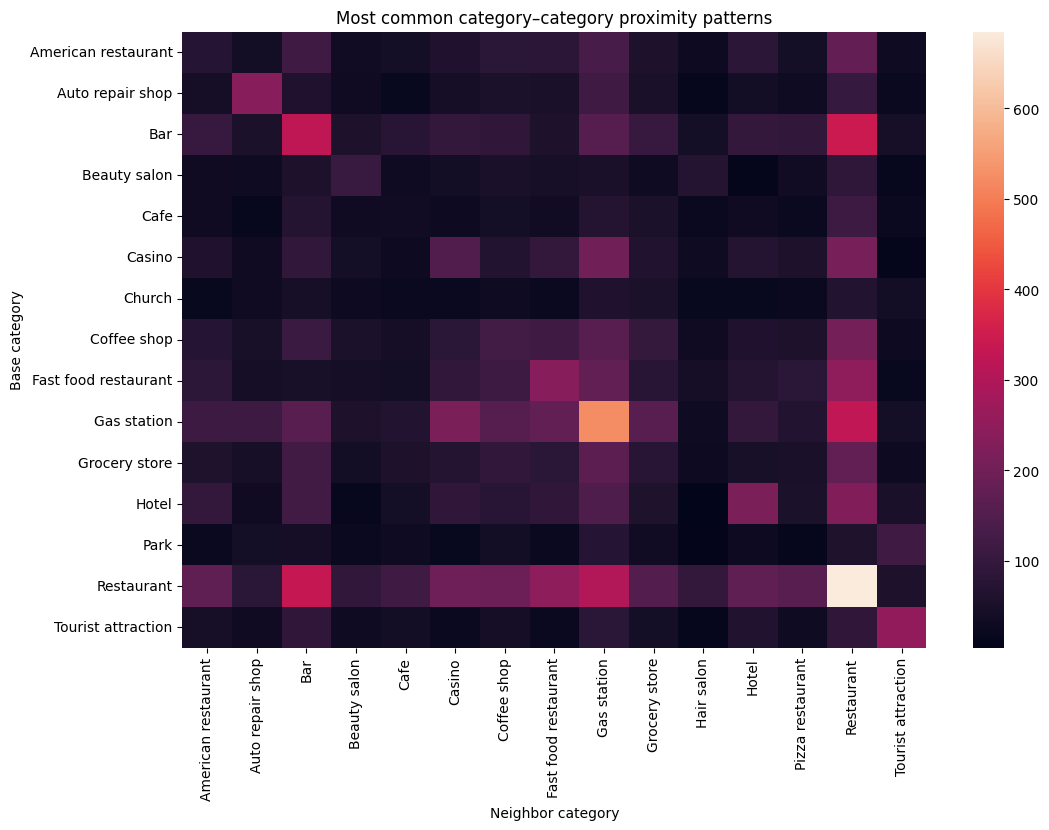

In [91]:


top_base = pair_counts["base_category"].value_counts().head(15).index
top_neigh = pair_counts["neighbor_category"].value_counts().head(15).index

pivot = pair_counts[
    pair_counts["base_category"].isin(top_base) &
    pair_counts["neighbor_category"].isin(top_neigh)
].pivot(
    index="base_category",
    columns="neighbor_category",
    values="count"
).fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=False)
plt.title("Most common category–category proximity patterns")
plt.xlabel("Neighbor category")
plt.ylabel("Base category")
plt.show()


Our analysis of the Montana Google Maps dataset reveals several clear structural patterns in how venues are geographically organized. By computing the 5-nearest neighbors for every location using geodesic (surface-based) distances and examining category-to-category co-occurrence frequencies, we observed that places tend to cluster into meaningful, functionally coherent groups.